# MiniFlow Deeper Dive

This Notebook is to take a deeper look at the MiniFlow Neural Network framework created in the Udacity Deep Learning Nanodegree Foundations.  The [MiniFlow Class](miniflow.py) was created during the Udacity lessons and the copy included here is from the solution set.

There are a few things I would like to explore:
1. Visualizing the tutorial test case in a Jupyter Notebook
2. Expanding the Network to a slightly more complicated configuration
3. Running this code on my ARM/FPGA (Pynq) Development Board for performance comparisons

## The Basic Configuration

The following is a replication of the base example given in the course lesson, but broken out in a more detailed way for viewing in this Notebook.

In [1]:
# Bring in the required libraries

# We use numpy for creating tensors (N-dimensional Arrays)
import numpy as np

# Our test dataset will come from the scikit-learn data set of Boston Housing
from sklearn.datasets import load_boston

# To perform Stochastic Gradient Decent use shuffle/resample on the base dataset
from sklearn.utils import shuffle, resample

# Miniflow is a custom set of classes derived from the Node base class
from miniflow import *

import matplotlib.pyplot as plt
%matplotlib inline

Next, we load in our data set with both features and targets based on those features.  We normalize the data because it is much easier to deal with values between 1 and 0 when picking hyperparameter values.

In [2]:
# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

# Create holder for weights and bias values
n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)


Now we configure the Neural Network using the MiniFlow classes to create a simple network as shown in the following image:

<img src=two-layer-graph.png>
 [Image: Udacity]

Every node in this image is a class with a member function called forward and backwards which supports forward and backward propagation.

In [3]:
# Neural network configuration
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

To avoid calculation dependency problems we will sort the network into the a safe order of operations using the [Kahn Algorithm](https://en.wikipedia.org/wiki/Topological_sorting#Kahn.27s_algorithm).  An example of what this does is in the following image where some parallel operations are reordered to ensure all dependent data is calculated first.

<img src=topological-sort.jpeg> [Image: Udacity]

While this is useful for a serial processing system I'm curious how to handle this in a device like an FPGA which is capable of doing truly parallel processing.



In [4]:
# Sort processing and initialize with starting values
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}
graph = topological_sort(feed_dict)

Now we have a configured network and can begin the processing interations using a forward pass to get an initial classification, then backwards propagation of the cost/loss of the prediction and also calculating a gradient to determine which direction we need to nudge the system to get a lower cost in the next prediction.  This process is repeated, using a new set of data each time by taking a random subset of the test data, until we reach the configured number of **epochs**.

In [5]:
epochs = 100

# Total number of examples
m = X_.shape[0]
batch_size = 11
steps_per_epoch = m // batch_size
trainables = [W1, b1, W2, b2]
learning_rate = .01

print("Total number of examples = {}".format(m))

Total number of examples = 506


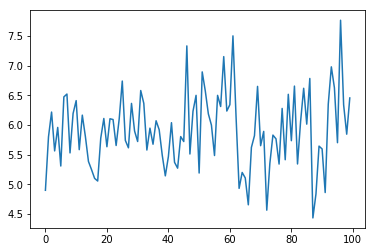

In [11]:
results = []
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables,learning_rate)

        loss += graph[-1].value

    #print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
    results.append(loss/steps_per_epoch)
plt.plot(results)

The previous graph shows the loss for each run of the epoch count.  It is clear that the loss initially was high but decreased quickly and converged on a loss value.  This is from the gradient decent finding a minimum in the loss function and working to find the optimal value but bouncing back and forth in a trough.

If we were to change the learning rate to something smaller it should converge to a much tighter final result, but it will take it longer to get there.  Now we will try running with a learning rate 10% of the previous value.

Total number of examples = 506


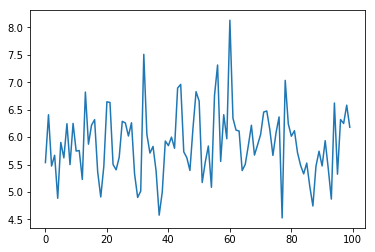

In [12]:
# Neural network configuration
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

# Sort processing and initialize with starting values
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}
graph = topological_sort(feed_dict)

epochs = 100

# Total number of examples
m = X_.shape[0]
batch_size = 11
steps_per_epoch = m // batch_size
trainables = [W1, b1, W2, b2]
learning_rate = .001  # 10% Previous learning rate

print("Total number of examples = {}".format(m))

results = []
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables,learning_rate)

        loss += graph[-1].value

    #print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
    results.append(loss/steps_per_epoch)
plt.plot(results)